In [11]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder

In [13]:
data_dir='/content/drive/MyDrive/PlantDisease/Data'
categories=os.listdir(data_dir)

# Load images and Labels
images=[]
labels=[]

for category in categories:
  print(category)
  folder_path=os.path.join(data_dir,category)
  for img_file in os.listdir(folder_path):
    img_path=os.path.join(folder_path,img_file)
    img=cv2.imread(img_path)
    if img is not None:
      img=cv2.resize(img,(64,64))
      images.append(img)
      labels.append(category)

# Convert images and labels to numpy array
images=np.array(images)

Tomato___Target_Spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_mosaic_virus
Tomato___Late_blight
Tomato___healthy


In [14]:
# convert to numpy arrays
x=np.array(images)
y=np.array(labels)

print("Label:",np.unique(y))
print("Data shape:",x.shape)

Label: ['Tomato___Late_blight' 'Tomato___Target_Spot'
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus' 'Tomato___Tomato_mosaic_virus']
Data shape: (7204, 64, 64, 3)


Class Distribution:
Tomato___Tomato_Yellow_Leaf_Curl_Virus    1991
Tomato___Target_Spot                      1827
Tomato___Tomato_mosaic_virus              1790
Tomato___Late_blight                      1596
Name: count, dtype: int64


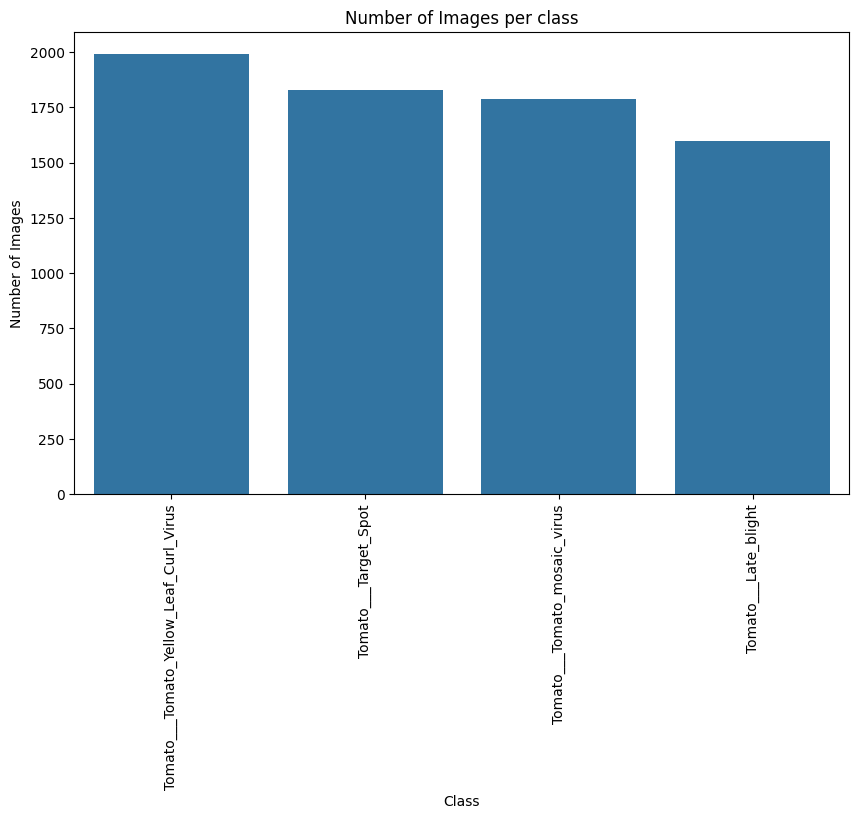

In [16]:
class_counts=pd.Series(y).value_counts()
print("Class Distribution:")
print(class_counts)

# Plot class distribution
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,6))
sns.barplot(x=class_counts.index,y=class_counts.values)
plt.xticks(rotation=90)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per class')
plt.show()

In [18]:
# Remove corrupted images
valid_images = []
valid_labels = []

for img, label in zip(x,y):
  if img.shape == (64, 64, 3):
    valid_images.append(img)
    valid_labels.append(label)

x=np.array(valid_images)
y=np.array(valid_labels)

print("Cleaned Data shape:",x.shape)

Cleaned Data shape: (7204, 64, 64, 3)


In [19]:
#Encode Labels
le=LabelEncoder()
y_encode = le.fit_transform(y)

#save class names for later use
class_names = le.classes_
class_names

array(['Tomato___Late_blight', 'Tomato___Target_Spot',
       'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
       'Tomato___Tomato_mosaic_virus'], dtype='<U38')

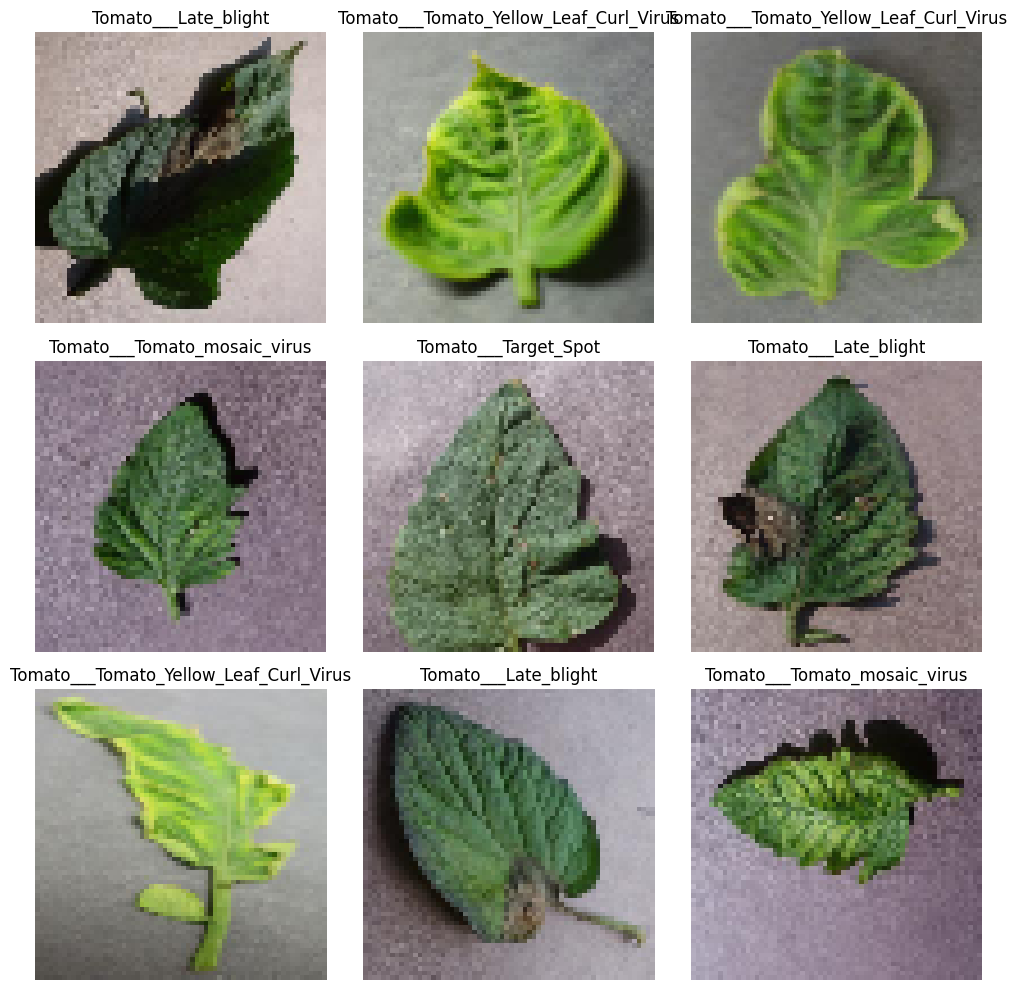

In [21]:
import random

plt.figure(figsize=(10,10))
for i in range(9):
  idx = random.randint(0, len(x))
  plt.subplot(3,3,i+1)
  plt.imshow(cv2.cvtColor(x[idx],cv2.COLOR_BGR2RGB))
  plt.title(class_names[y_encode[idx]])
  plt.axis('off')
plt.tight_layout()
plt.show()

In [22]:
def extract_color_histogram(image,bins=(8,8,8)):

  image=cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
  hist=cv2.calcHist([image],[0,1,2],None,bins,[0,256,0,256,0,256])
  hist=cv2.normalize(hist,hist).flatten()
  return hist

hist_features=[extract_color_histogram(img) for img in x]
x_features=np.array(hist_features)


In [23]:
x_features.shape

(7204, 512)

In [26]:
#choose model
model=SVC(kernel='linear',C=10,gamma='scale')
#Train model/test split
X_train,X_test,y_train,y_test=train_test_split(x_features,y_encode,test_size=0.2,random_state=42)
#train model
model.fit(X_train,y_train)
#predict
y_pred=model.predict(X_test)

Accuracy: 0.981263011797363
F1 Score: 0.9812187486785016


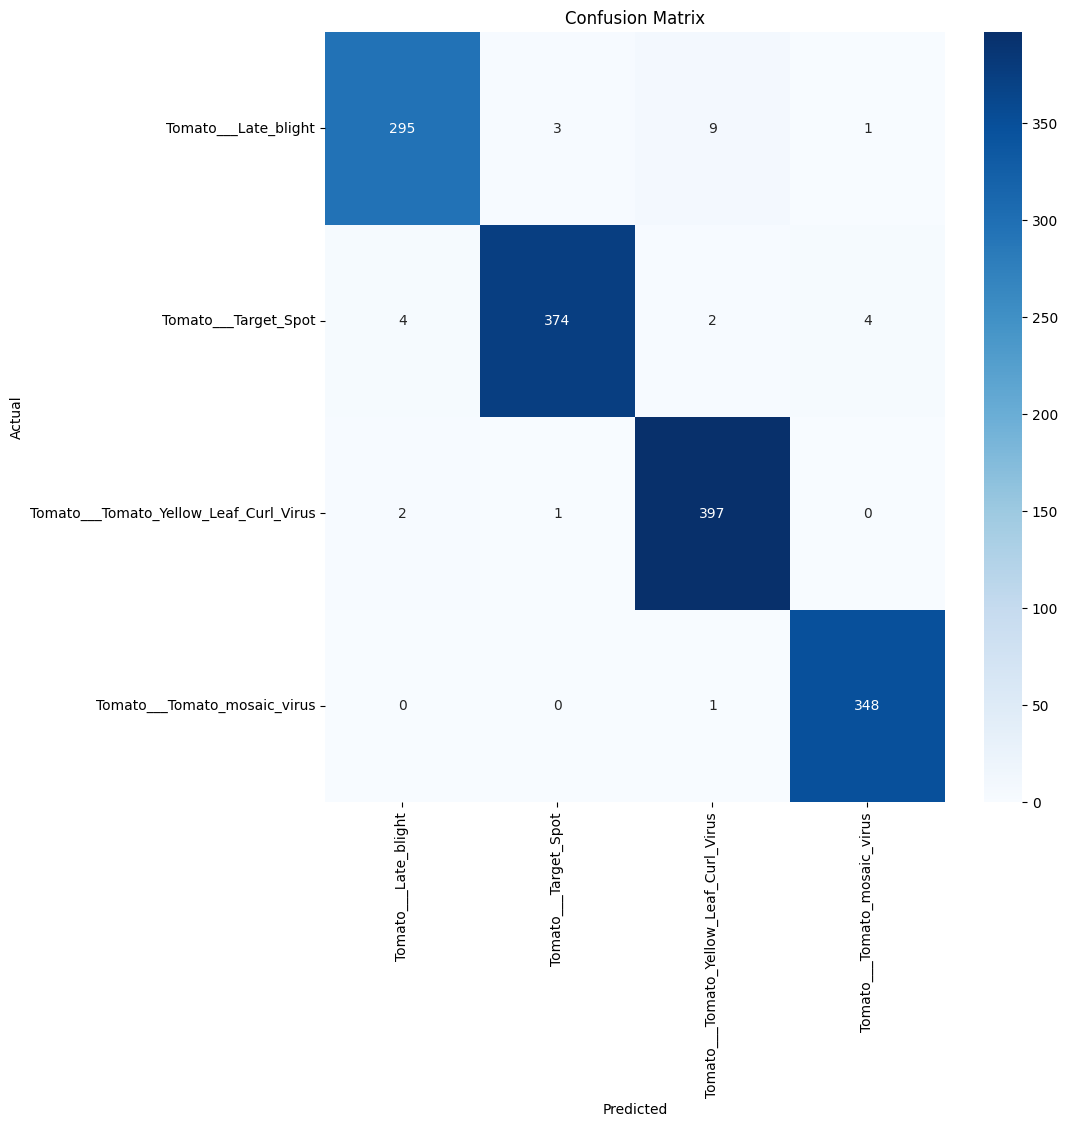

In [27]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report

#Accuracy
acc=accuracy_score(y_test,y_pred)
print("Accuracy:",acc)

#F1 Score
f1=f1_score(y_test,y_pred,average='weighted')
print("F1 Score:",f1)

#Confusion Matrix
cm=confusion_matrix(y_test,y_pred)

#plot Comfusion Matrix
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [28]:
#classification Report
print("Classification Report:")
print(classification_report(y_test,y_pred,target_names=class_names))

Classification Report:
                                        precision    recall  f1-score   support

                  Tomato___Late_blight       0.98      0.96      0.97       308
                  Tomato___Target_Spot       0.99      0.97      0.98       384
Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.97      0.99      0.98       400
          Tomato___Tomato_mosaic_virus       0.99      1.00      0.99       349

                              accuracy                           0.98      1441
                             macro avg       0.98      0.98      0.98      1441
                          weighted avg       0.98      0.98      0.98      1441

